# Computer Assignment #5

## Regression

- **Ali Hamzehpour 810100129**
- **Mina Shirazi 810100250**
- **Mohammad Amin Yousefi 810100236**

### Summary

In this assignment, we are asked to perform preprocessing and feature engineering on a football related dataset. Then we should implement a regression model using gradient descent and test it on a car related dataset. After that we have to implement k-fold cross validation to evaluate the model. Finally, we compare our model with the sklearn's implementation.

## Part 1: Preprocessing

In this part we are given a dataset of shots in football matches. We should preprocess the data and extract beneficial features from it.

#### **Understanding the Dataset**   

First we load the dataset and take a look at its first rows to understand the structure of the data.



In [272]:
import pandas as pd

df = pd.read_csv("football.csv")

In [273]:
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


We check the statistics of the numerical columns:

In [274]:
df.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.00,8925.00,8925.00,8925.00,8925.00,8925.00
mean,14.56,0.36,2.53,0.34,48.54,29.24
std,7.84,9.00,1.39,0.68,26.40,17.31
min,0.00,-33.92,0.00,0.00,0.00,0.00
25%,8.48,-5.74,2.00,0.00,26.00,14.00
50%,12.47,0.50,2.00,0.00,49.00,29.00
75%,20.95,6.73,3.00,0.00,71.00,44.00
max,70.82,33.92,11.00,7.00,98.00,59.00


We also check the data types of the columns:

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


#### **Handling Missing Values**

From the last section we could see that we had some missing values in some columns. We use `isnull().sum()` to precisely check the number of missing values in each column. We can see that the columns `interferenceOnShooter` and `outcome` both has 34 missing values and other columns are fine.

In [276]:
null_count = df.isnull().sum()
print(null_count)

matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64


We check if the same rows both have missing values in `interferenceOnShooter` and `outcome` columns. We can see that the rows with missing values in `interferenceOnShooter` are the same as the rows with missing values in `outcome` column. So totally we only have 34 rows with missing values in these two columns and because we have more than 8000 rows, we can safely drop rows with missing values.

In [277]:
null_outcome_rows = df[df['outcome'].isnull() & df['interferenceOnShooter'].isnull()]

len(null_outcome_rows)

34

In [278]:
df = df.dropna()

#### **Duplications**
We check if there are any duplicated rows in the dataset. We can see that there are no duplicated rows in the dataset.

In [279]:
print("Before duplicates removal: ", len(df))
df = df.drop_duplicates()
print("After duplicates removal: ", len(df))

Before duplicates removal:  8891
After duplicates removal:  8891


#### **Checking Columns' unique values**

In this section we check each column's value counts and make some changes to make the dataset better for analysis and machine learning models.

##### **matchId**

The match shouldn't have much imapct on the outcome of the shot and we also have so many unique values for this column. So we drop this column.

In [280]:
len(df["matchId"].unique())

240

In [281]:
df = df.drop(columns=["matchId"])

##### **playerId**

we have about 160 unique values for this column. we keep it for now.

In [282]:
df["playerId"].unique().size

160

##### **playType**

We can see that we have 4 unique values for `playType` column:

* open play
* free kick
* penalty
* olimpico (which is trying to score from a corner.)

Because the number of rows with `olimpico` value is very low, we can drop them or merge them with `free kick` rows. We choose to merge them with `free kick` rows.

In [283]:
df["playType"].value_counts()

playType
open play    8344
free kick     417
penalty       126
olimpico        4
Name: count, dtype: int64

In [284]:
df["playType"] = df["playType"].replace("olimpico", "free kick")

We also check if all penalties are shot from a certain point. If we have some penalty shots with different `x` and `y` values we should drop them but we can see that all of them are shot from the same point.

In [285]:
penalties = df[df["playType"] == "penalty"]
print(penalties["x"].value_counts())
print(penalties["y"].value_counts())


x
10.97    126
Name: count, dtype: int64
y
0.00    126
Name: count, dtype: int64


##### **bodyPart**

The first obvious thing we can do is to merge `head` and `other` because we have only few rows with `bodyPart` = `other`

In [286]:
df["bodyPart"].value_counts()

bodyPart
right foot    4440
left foot     2892
head          1508
other           51
Name: count, dtype: int64

In [287]:
df["bodyPart"] = df["bodyPart"].replace("head", "other")

In [288]:
# df["withFoot"] = df["bodyPart"].apply(lambda x: 1 if x == "right foot" or x == "left foot" else 0)
# df.drop(columns=["bodyPart"], inplace=True)

##### **interferenceOnShooter**

In [289]:
df["interferenceOnShooter"].value_counts()

interferenceOnShooter
medium    4186
low       3315
high      1390
Name: count, dtype: int64

##### **outcome** 

We can see that we have 5 different outcomes: `missed chance`, `saved by keeper`, `blocked shot`, `hit the post` and `goal`. 4 of them are non-goal results and one of them is goal. we add a new column named `goal` which determines if the outcome of the shot is goal or not.

In [290]:
df["outcome"].value_counts()

outcome
missed chance      3470
saved by keeper    2395
blocked shot       1771
goal               1081
hit the post        174
Name: count, dtype: int64

In [291]:
df["goal"] = df["outcome"].apply(lambda x: 1 if x == "goal" else 0)
df = df.drop(columns = ["outcome"])
df.head()

,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,goal
0,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,1
1,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,0
2,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,0
3,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,0
4,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,1


#### **Adding Distance and Angle to Dataset**

We can generate more useful features from `x` and `y` column. we can define `distance` as below:

$$ distance = \sqrt{x^2 + y^2}$$

In [292]:
df["distance"] = (df["x"]**2 + df["y"]**2)**0.5
df.head()

,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,goal,distance
0,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,1,17.53
1,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,0,17.09
2,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,0,29.46
3,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,0,26.95
4,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,1,11.93


In [293]:
df["distance"].describe()

count   8891.00
mean      17.18
std        7.78
min        0.35
25%       10.97
50%       15.92
75%       23.66
max       71.78
Name: distance, dtype: float64

We can also define the angle of the shot as below:

$$ angle = \begin{cases}
    rad2deg(\arctan(\theta)) & \text{if } \arctan(\theta) \geq 0 \\
    rad2deg(\arctan(\theta) + \pi) & \text{if } \arctan(\theta) \lt 0
\end{cases}$$

where 

$$ \theta = \frac{7.32 x}{x^2 + y^2  - (\frac{7.32}{2})^2}

In [294]:
import math
theta = 7.32 * df["x"] / (df["x"]**2 + df["y"]**2 - (7.32/2)**2)
arc_theta = theta.apply(lambda x: math.atan(x) if math.atan(x) > 0 else math.atan(x) + math.pi)
df["angle"] = arc_theta.apply(lambda x: math.degrees(x))
df.head()

,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,goal,distance,angle
0,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,1,17.53,18.54
1,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,0,17.09,13.98
2,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,0,29.46,14.15
3,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,0,26.95,15.46
4,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,1,11.93,31.32


In [295]:
df["angle"].describe()

count   8891.00
mean      26.15
std       17.25
min        0.09
25%       14.93
50%       19.93
75%       32.73
max      180.00
Name: angle, dtype: float64

So now that we have `distance` and `angle` we can drop `x` and `y` columns since these two columns are more informative.

In [296]:
#df.drop(columns=["x", "y"], inplace=True)

#### **Converting Categorical to Numerical**

In this part we convert the categorical columns to numerical because it's easier to work with numerical features in statistical analysis and machine learning models.

We use label encoding since we don't wanna increase the complexity of data for computations.

In [297]:
df["playType"] = df["playType"].map({"open play": 0, "free kick": 1, "penalty": 2})

In [298]:
df["bodyPart"] = df["bodyPart"].map({"left foot": 0, "right foot": 1, "other": 2})

In [299]:
df["interferenceOnShooter"] = df["interferenceOnShooter"].map({"low": 0, "medium": 1, "high": 2})

In [300]:
df['playerId'] = df['playerId'].str.extract(r'p_(\d+)').astype(int)

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   playerId               8891 non-null   int32  
 1   playType               8891 non-null   int64  
 2   bodyPart               8891 non-null   int64  
 3   x                      8891 non-null   float64
 4   y                      8891 non-null   float64
 5   interveningOpponents   8891 non-null   int64  
 6   interveningTeammates   8891 non-null   int64  
 7   interferenceOnShooter  8891 non-null   int64  
 8   minute                 8891 non-null   int64  
 9   second                 8891 non-null   int64  
 10  goal                   8891 non-null   int64  
 11  distance               8891 non-null   float64
 12  angle                  8891 non-null   float64
dtypes: float64(4), int32(1), int64(8)
memory usage: 937.7 KB


#### **Visualizations**

In this part we use visualizations to undrestand the relationship between features and target in order to clean the data and find better features.



##### **Average Goals based on Minute of the game**
We plot the average goal per shot in each minute of the game and we can see beside 95+ minute, the average number of goals is approximately constant.

and if we check the number of 95+ shots, we can see that there are only 11 of them so we can say the `minute` and `second` column doesn't have significant relation with the outcome of the shot so we drop it.

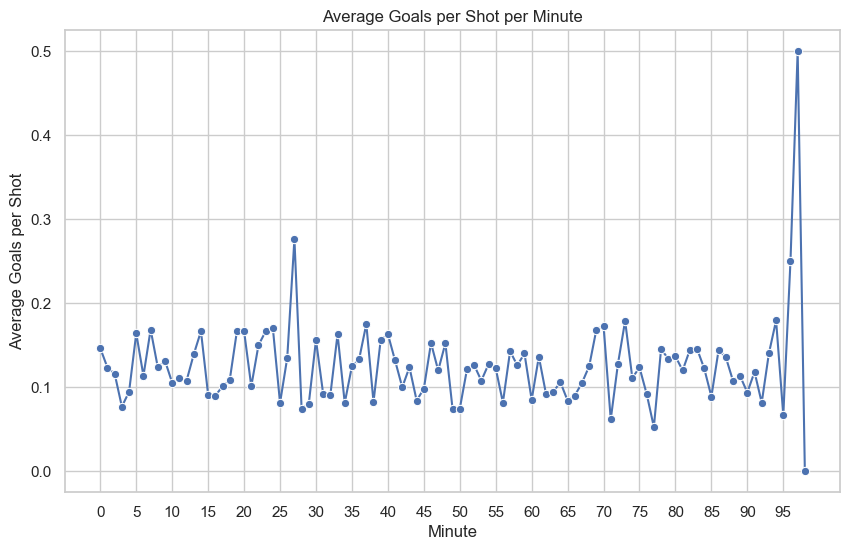

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns

goals_per_minute = df.groupby('minute')['goal'].agg(goals='sum', shots='size').reset_index()

goals_per_minute['avg_goals_per_shot'] = goals_per_minute['goals'] / goals_per_minute['shots']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='minute', y='avg_goals_per_shot', data=goals_per_minute, marker='o')
plt.xlabel('Minute')
plt.ylabel('Average Goals per Shot')
plt.title('Average Goals per Shot per Minute')
plt.xticks(range(0, max(goals_per_minute['minute'])+1, 5))

plt.show()

In [303]:
len(df[df["minute"] > 95])

11

In [304]:
df_pp = df.drop(columns = ["minute", "second"])

##### **Average Goals per Player**

We can see that some players have significant higher goal but since we have so many unique values for `playerId`, we will need a very complex model to capture the effect of each player on the outcome of the shot. So we drop this column.

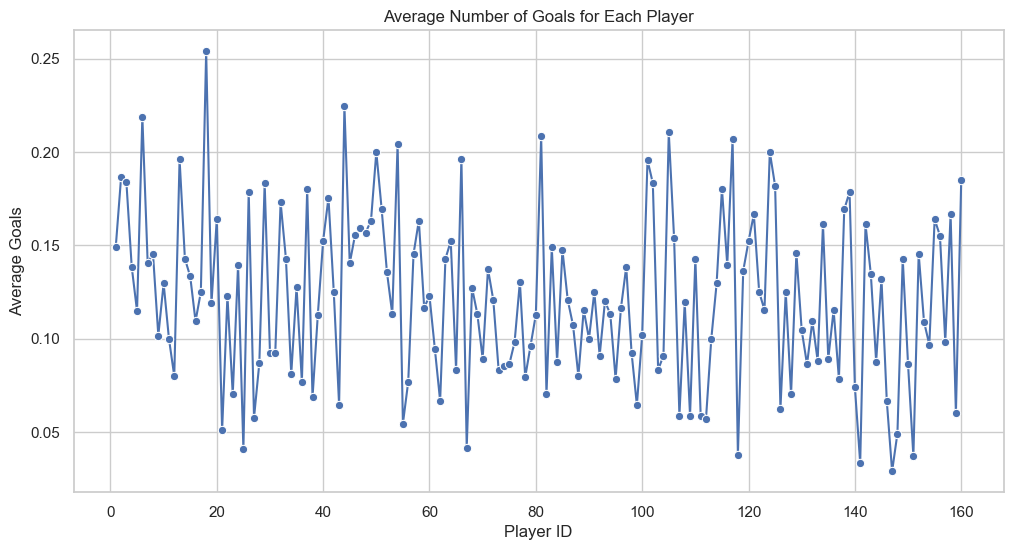

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt

average_goals = df.groupby('playerId')['goal'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_goals, x='playerId', y='goal', marker='o')

plt.xlabel('Player ID')
plt.ylabel('Average Goals')
plt.title('Average Number of Goals for Each Player')

plt.show()

In [306]:
df_pp = df_pp.drop(columns = ["playerId"])

##### **Average Number of goals per Distance**

We can see that the average number of goals per distance is decreasing as the distance increases but we have a starnge peak when the distance is between 57 and 64. so we check the shots with distance > 57 and we see there are only 5 of them so we won't use them in our model.

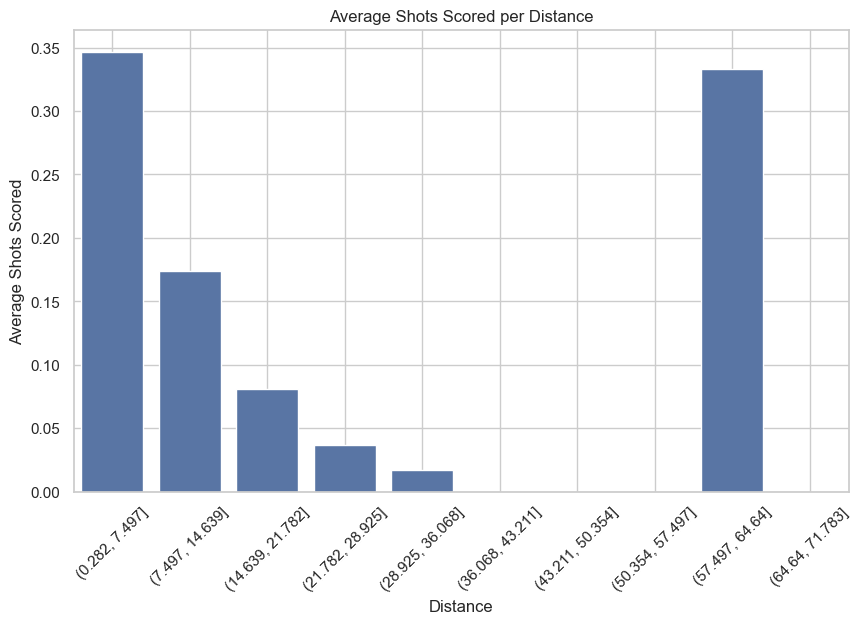

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

df['distance_bins'] = pd.cut(df['distance'], bins=10)

average_shots_per_distance = df.groupby('distance_bins', observed=False)['goal'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=average_shots_per_distance, x='distance_bins', y='goal')
plt.xlabel('Distance')
plt.ylabel('Average Shots Scored')
plt.title('Average Shots Scored per Distance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df.drop(columns=['distance_bins'], inplace=True)


In [308]:
len(df[df["distance"] > 57])

5

In [309]:
df_pp = df_pp[df_pp["distance"] < 57]

##### **Average Number of goals per Angle**

We can see that the average number of goals per angle is increasing as the angle increases which is logical.

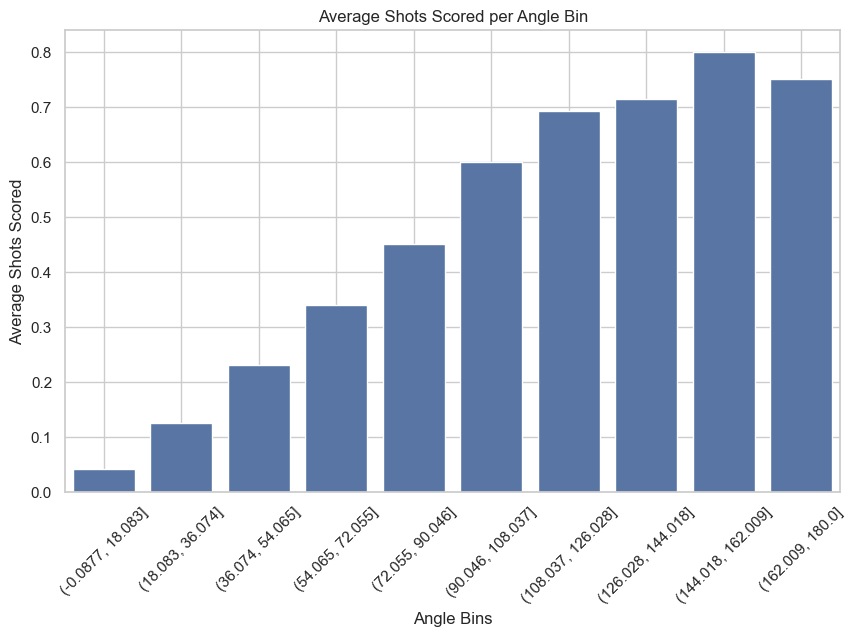

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt

df['angle_bins'] = pd.cut(df['angle'], bins=10)

average_shots_per_angle = df.groupby('angle_bins', observed=False)['goal'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=average_shots_per_angle, x='angle_bins', y='goal')
plt.xlabel('Angle Bins')
plt.ylabel('Average Shots Scored')
plt.title('Average Shots Scored per Angle Bin')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df.drop(columns=['angle_bins'], inplace=True)


##### **Average Number of goals per Angle**

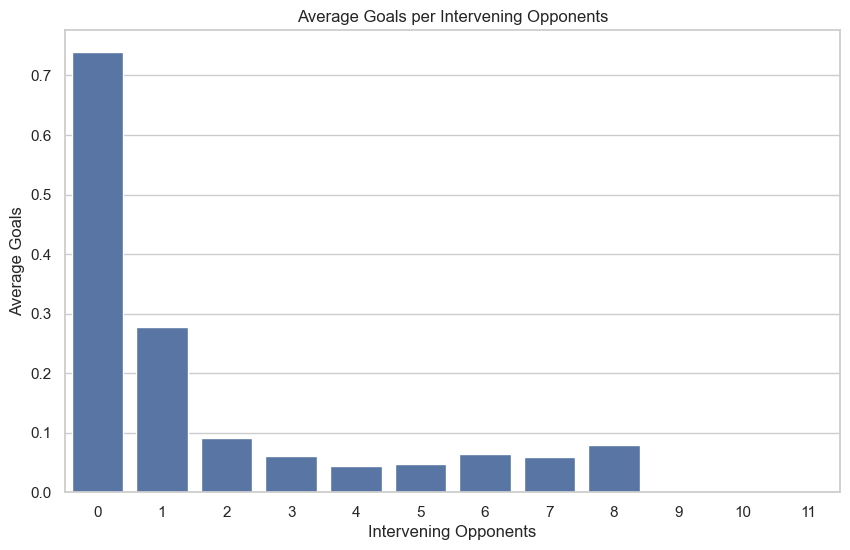

In [311]:
df_average_goals = df.groupby('interveningOpponents')['goal'].mean()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=df_average_goals.index, y=df_average_goals.values)
plt.xlabel('Intervening Opponents')
plt.ylabel('Average Goals')
plt.title('Average Goals per Intervening Opponents')
plt.show()


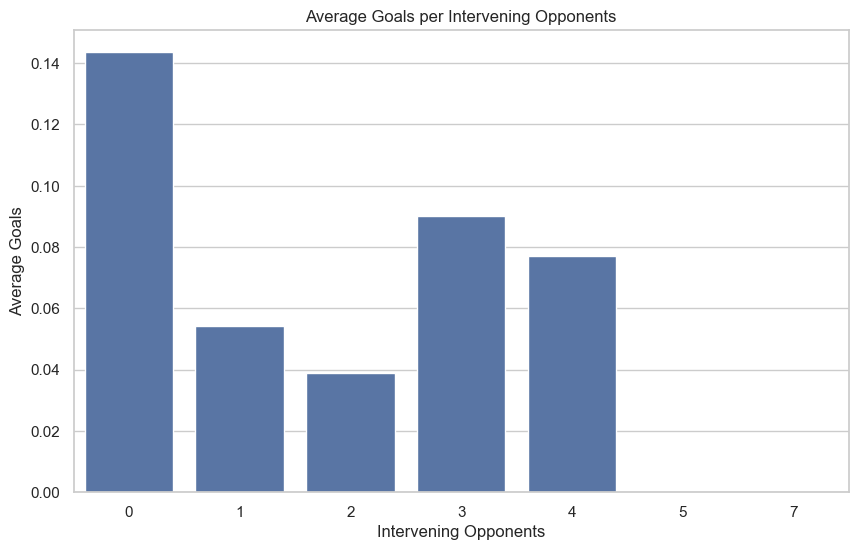

In [312]:
df_average_goals = df.groupby('interveningTeammates')['goal'].mean()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=df_average_goals.index, y=df_average_goals.values)
plt.xlabel('Intervening Opponents')
plt.ylabel('Average Goals')
plt.title('Average Goals per Intervening Opponents')
plt.show()


##### **Location of shots and goals**

We created an interesting plot to show the location of shots and goals on the pitch. We can see that goals are most likely to be scored from the inside of the box.

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_pitch():
    sns.set_style("whitegrid", {'axes.grid': False})
    fig, ax = plt.subplots(figsize=(10, 6))

    # Pitch Outline & Centre Line
    plt.plot([0, 0], [0, 68], color="black")
    plt.plot([0, 130], [68, 68], color="black")
    plt.plot([130, 130], [68, 0], color="black")
    plt.plot([130, 0], [0, 0], color="black")
    plt.plot([65, 65], [0, 68], color="black")

    # Left Penalty Area
    plt.plot([16.5, 16.5], [55.5, 12.5], color="black")
    plt.plot([0, 16.5], [55.5, 55.5], color="black")
    plt.plot([16.5, 0], [12.5, 12.5], color="black")

    # Right Penalty Area
    plt.plot([130, 113.5], [55.5, 55.5], color="black")
    plt.plot([113.5, 113.5], [55.5, 12.5], color="black")
    plt.plot([113.5, 130], [12.5, 12.5], color="black")

    # Left 6-yard Box
    plt.plot([0, 5.5], [48, 48], color="black")
    plt.plot([5.5, 5.5], [48, 20], color="black")
    plt.plot([5.5, 0.5], [20, 20], color="black")

    # Right 6-yard Box
    plt.plot([130, 124.5], [48, 48], color="black")
    plt.plot([124.5, 124.5], [48, 20], color="black")
    plt.plot([124.5, 130], [20, 20], color="black")

    # Prepare Circles; 10 yard circle at centre
    centreCircle = plt.Circle((65, 34), 9.15, color="black", fill=False)

    # Draw Circles
    ax.add_patch(centreCircle)

    # Penalty spots and centre spot
    plt.scatter(65, 34, color="black")
    plt.scatter(11, 34, color="black")
    plt.scatter(119, 34, color="black")

    # Axis titles and limits
    plt.xlim(-1, 131)
    plt.ylim(-1, 69)
    plt.axis("off")

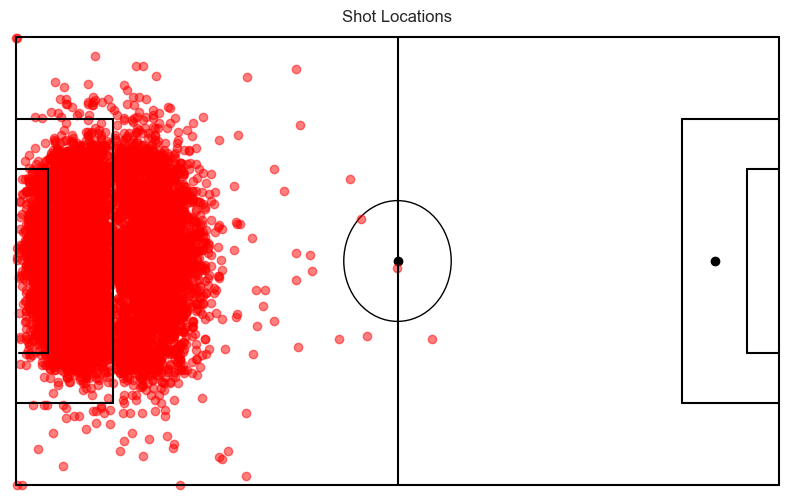

In [314]:
draw_pitch()
plt.scatter(df['x'], df['y'] - min(df['y']), color='red', alpha=0.5)
plt.title('Shot Locations')
plt.show()


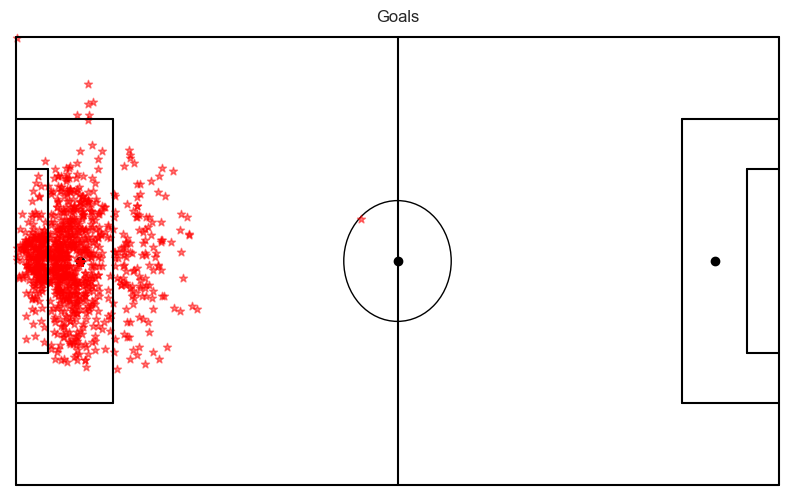

In [315]:
df_goals = df[df['goal'] == 1]
draw_pitch()
plt.scatter(df_goals['x'], df_goals['y'] - min(df['y']), color='red', alpha=0.5, marker="*")
plt.title("Goals")
plt.show()

#### **Mutual Information**


The Mutual Information (MI) method is a concept from information theory used in various fields, including statistics, machine learning, and signal processing. It measures the amount of information obtained about one random variable through observing another random variable. We use this method to check which features in our data are more informative about the target.

In [316]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop(columns=["goal"])
y = df["goal"]

mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)
mi_df

,Feature,Mutual_Information
11,angle,0.06
10,distance,0.05
5,interveningOpponents,0.04
3,x,0.04
4,y,0.03
1,playType,0.02
7,interferenceOnShooter,0.01
6,interveningTeammates,0.01
0,playerId,0.00
8,minute,0.00


We can see that `bodyPart` is not that informative so we drop it.

In [317]:
df_pp = df_pp.drop(columns=['bodyPart'])

#### **Testing with Classifier Models**

We use `LazyClassifier` to check the performance of different classifier models on the dataset. 

##### **df with less preprocessing**

In [318]:
df.columns

Index(['playerId', 'playType', 'bodyPart', 'x', 'y', 'interveningOpponents',
       'interveningTeammates', 'interferenceOnShooter', 'minute', 'second',
       'goal', 'distance', 'angle'],
      dtype='object')

In [319]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=['goal', 'distance', 'angle'])
y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:06<00:00,  4.16it/s]

[LightGBM] [Info] Number of positive: 866, number of negative: 6246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 7112, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121766 -> initscore=-1.975812
[LightGBM] [Info] Start training from score -1.975812


In [320]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.69,0.70,0.70,0.74,0.01
LabelPropagation,0.84,0.61,0.61,0.83,1.33
LabelSpreading,0.84,0.60,0.60,0.83,2.19
DecisionTreeClassifier,0.82,0.60,0.60,0.82,0.03
XGBClassifier,0.88,0.60,0.60,0.86,0.10
LGBMClassifier,0.89,0.59,0.59,0.86,0.08
BaggingClassifier,0.88,0.59,0.59,0.86,0.18
ExtraTreeClassifier,0.80,0.58,0.58,0.81,0.01
PassiveAggressiveClassifier,0.85,0.58,0.58,0.84,0.01


##### **df with more prepocessing**

In [321]:
df_pp.columns

Index(['playType', 'x', 'y', 'interveningOpponents', 'interveningTeammates',
       'interferenceOnShooter', 'goal', 'distance', 'angle'],
      dtype='object')

In [322]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = df_pp.drop(columns=['goal'])
y = df_pp['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:06<00:00,  4.29it/s]

[LightGBM] [Info] Number of positive: 862, number of negative: 6246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 868
[LightGBM] [Info] Number of data points in the train set: 7108, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121272 -> initscore=-1.980441
[LightGBM] [Info] Start training from score -1.980441


In [323]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.74,0.74,0.74,0.78,0.01
GaussianNB,0.86,0.65,0.65,0.86,0.01
BernoulliNB,0.87,0.64,0.64,0.86,0.01
QuadraticDiscriminantAnalysis,0.89,0.63,0.63,0.87,0.01
ExtraTreeClassifier,0.84,0.62,0.62,0.84,0.01
LinearDiscriminantAnalysis,0.89,0.61,0.61,0.87,0.01
KNeighborsClassifier,0.89,0.61,0.61,0.86,0.07
DecisionTreeClassifier,0.84,0.60,0.60,0.83,0.03
LabelPropagation,0.88,0.60,0.60,0.86,1.32


##### **Analysis**

We use `ROC AUC` metric rather than `accuracy` to determine the performance of the models because the dataset is imbalanced and the accuracy is not a good metric for imbalanced datasets.

`ROC AUC`: An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

$$ TPR = \frac{TP}{TP + FN}$$

False Positive Rate (FPR) is defined as follows:

$$ FPR = \frac{FP}{FP + TN}$$

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

<div style="text-align:center; ">
    <img src="rocauc.png" alt="SVG Image" width="600">
</div>

We can see the model on preprocessed data has higher `AUC ROC` and the best models for classifying the data is `NearestCentroid`.


### Loading The Dataset For Part 2 and 3


In [324]:
import pandas as pd

df = pd.read_csv('cars.csv')

In [325]:
df.head()

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.92,16.36,21.50,1.80,140,101.20,67.30,172.40,2.64,13.20,28,58.28,0,1
1,39.38,19.88,28.40,3.20,225,108.10,70.30,192.90,3.52,17.20,25,91.37,0,1
2,20.40,22.25,23.99,1.80,150,102.60,68.20,178.00,3.00,16.40,27,62.78,0,1
3,18.78,23.55,33.95,2.80,200,108.70,76.10,192.00,3.56,18.50,22,84.57,0,1
4,91.56,12.47,21.98,3.10,175,109.00,72.70,194.60,3.37,17.50,25,71.18,0,1


In [326]:
df.describe()

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,66.59,14.11,21.30,2.87,166.59,107.30,70.99,187.57,3.26,17.48,24.57,67.89,0.28,0.72
std,78.51,4.57,6.76,0.89,42.59,7.91,3.63,14.04,0.58,3.87,4.49,17.56,0.45,0.45
min,0.11,5.16,9.23,1.00,55.00,93.10,62.60,149.40,1.90,10.30,15.00,23.28,0.00,0.00
25%,20.39,10.59,16.54,2.00,132.00,102.55,68.30,177.90,2.89,15.07,22.00,53.53,0.00,0.00
50%,37.65,13.45,20.47,2.75,165.50,106.70,70.30,186.45,3.27,17.00,25.00,67.33,0.00,1.00
75%,80.76,16.88,25.47,3.50,200.00,109.82,73.20,195.15,3.59,19.00,27.00,81.21,1.00,1.00
max,540.56,26.98,39.66,5.20,275.00,138.70,79.30,224.50,4.81,32.00,45.00,113.77,1.00,1.00


## Part 2: Multivariate Regression Implementation

In this part, we are given a preprocessed dataset that contains information about cars (cars.csv). We are supposed to implement multivariate regression from scratch and use the gradient descent algorithm to update the weights and compare it's result with results of using libraries. 

- ```predict_output: ``` Calculates the dot product of the feature_matrix and weights and adds the bias to the result. The function returns the calculated predictions.

- ```feature_derivative: ``` Calculates the derivative of the squared error with respect to a specific feature. The derivative is calculated as twice the dot product of errors and feature. The function returns the calculated derivative.

In [327]:
import numpy as np

def predict_output(feature_matrix, weights, bias):
    predictions = np.dot(feature_matrix, weights)
    predictions += bias
    return predictions

def feature_derivative(errors, feature):
    derivative = 2 * np.dot(errors, feature)
    return derivative

Now we implement ```regression_gradient_descent``` to performs gradient descent to minimize the squared error in a linear regression model.
The function iteratively updates the weights and bias using gradient descent until the gradient becomes small enough (below the specified tolerance). It calculates predictions based on the current weights and bias, calculates the errors by subtracting the predictions from the actual outputs, and then calculates the gradients using the feature_derivative function.
The weights and bias are updated by subtracting the product of the gradients and the step size from their current values. This process is repeated until the convergence criterion is met.
Finally, the function returns the optimized weights and bias.

In [328]:
import numpy as np

def regression_gradient_descent(feature_matrix, outputs, initial_weights, bias, step_size, tolerance, max_epochs):
    weights = np.array(initial_weights)
    converged = False
    for i in range(max_epochs):
        predictions = predict_output(feature_matrix, weights, bias)
        errors = outputs - predictions
        gradiant= -feature_derivative(errors, feature_matrix)
        weights = weights - step_size * gradiant
        bias_gradiant= -np.sum(errors)
        bias = bias - step_size * bias_gradiant
        if np.linalg.norm(gradiant) < tolerance:
            break
    return weights, bias


Next, we implement some functions to calculate ```R2-score``` and ```RMSE```. These functions are used to calculate evaluation metrics for a regression model. 

In [329]:
def get_r2_score(predicted_values, output):
    residuals = predicted_values - output
    SSres = (residuals ** 2).sum()
    SStot = ((output - output.mean())**2).sum()
    return 1 - SSres / SStot

def get_root_mean_square_error(predicted_values , output):
    residuals = predicted_values - output
    residuals_sum_sqr = (residuals ** 2).sum()
    mean_residual_sqr = residuals_sum_sqr/len(predicted_values)
    return math.sqrt(mean_residual_sqr)

- `normalize_features:` This function takes a list of `chosen_features` and a `data_frame` (Pandas DataFrame) as input. It normalizes the selected features in the DataFrame by subtracting the mean and dividing by the standard deviation. If the standard deviation is zero for a particular feature, it sets the feature values to zero.

- `n_feature_regression:` This function performs regression using gradient descent. It takes the `chosen_feature_matrix` (input feature matrix), `target_matrix` (target values), and `keywords` (a dictionary of keyword arguments) as input. The `keywords` dictionary contains the following keys:
   - `initial_weights`: An array of initial weights for the regression model.
   - `initial_bias`: The initial bias term for the regression model.
   - `step_size`: The step size or learning rate for gradient descent.
   - `tolerance`: The convergence tolerance for gradient descent.

   The function uses the `regression_gradient_descent` function to perform the actual gradient descent optimization and returns the final weights and bias terms.

- `get_weights_and_bias:` This function takes `X_train` (input feature matrix) and `y_train` (target values) as input. It initializes the `keywords` dictionary with the initial weights, step size, tolerance, and bias. It then calls the `n_feature_regression` function to obtain the chosen feature matrix, train weights, and bias. It returns these values as the output.

In [330]:
import numpy as np

MAX_EPOCHS = 1000000

def normalize_features(chosen_features, data_frame):
    for feature in chosen_features:
        feature_mean = data_frame[feature].mean()
        feature_std = data_frame[feature].std()
        if feature_std != 0:
            data_frame[feature] = (data_frame[feature] - feature_mean) / feature_std
        else:
            data_frame[feature] = 0

    return data_frame


def n_feature_regression(chosen_feature_matrix, target_matrix, keywords, max_epochs=MAX_EPOCHS):
    initial_weights = keywords['initial_weights']
    initial_bias = keywords['initial_weights'][-1]
    step_size = keywords['step_size']
    tolerance = keywords['tolerance']

    weights, bias = regression_gradient_descent(chosen_feature_matrix, target_matrix, initial_weights, initial_bias, step_size, tolerance, max_epochs)
    return weights, bias

def get_weights_and_bias(X_train, y_train, max_epochs=MAX_EPOCHS):
    keywords = {

        'initial_weights': np.random.normal(0, 1, X_train.shape[1]),
        'step_size': 1.e-4,
        'tolerance': 1.e-5,
        'bias': 0
    }

    chosen_feature_matrix = X_train

    target_column = y_train
    if type(target_column) is not np.ndarray:
        target_matrix = target_column.to_numpy()
    else:
        target_matrix = target_column
    
    train_weights, bias = n_feature_regression(chosen_feature_matrix, target_matrix, keywords, max_epochs)
    return chosen_feature_matrix, train_weights, bias

In [331]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(X_train, y_train, X_test, y_test):
    train_scores_r2 = []
    test_scores_r2 = []
    train_scores_rmse = []
    test_scores_rmse = []
    epochs = range(1, 2000, 5)
    for i in epochs:
        chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train, max_epochs=i)
        train_predictions = predict_output(chosen_feature_matrix, train_weights, bias)
        train_scores_r2.append(get_r2_score(train_predictions, y_train))
        train_scores_rmse.append(get_root_mean_square_error(train_predictions, y_train))
        test_predictions = predict_output(X_test, train_weights, bias)
        test_scores_r2.append(get_r2_score(test_predictions, y_test))
        test_scores_rmse.append(get_root_mean_square_error(test_predictions, y_test))
        
    
    ax, fig = plt.subplots(1, 2, figsize=(15, 5))
    fig[0].plot(epochs, train_scores_r2, label='Training R2')
    fig[0].plot(epochs, test_scores_r2, label='Testing R2')
    fig[0].set_title('R2 Score')
    fig[0].set_xlabel('Epochs')
    fig[0].set_ylabel('R2 Score')
    fig[0].legend()
    fig[1].plot(epochs, train_scores_rmse, label='Training RMSE')
    fig[1].plot(epochs, test_scores_rmse, label='Testing RMSE')
    fig[1].set_title('RMSE Score')
    fig[1].set_xlabel('Epochs')
    fig[1].set_ylabel('RMSE Score')
    fig[1].legend()

In [332]:
def plot_real_learning_curve(X_train, y_train, X_test, y_test, train_sizes):
    train_scores = []
    test_scores = []

    for size in train_sizes:
        train_subset_size = int(size * len(X_train))
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]

        chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train_subset, y_train_subset)

        train_predictions=predict_output(X_train_subset, train_weights,bias)
        RMSE_train = get_root_mean_square_error(train_predictions, y_train_subset)

        test_predictions=predict_output(X_test, train_weights, bias)
        RMSE_test = get_root_mean_square_error(test_predictions, y_test)

        train_scores.append(RMSE_train)
        test_scores.append(RMSE_test)
    
    plt.plot(train_sizes, train_scores, marker='o', label='Training Set')
    plt.plot(train_sizes, test_scores, marker='o', label='Test Set')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

#### Target Variable: Price in Thousands
After normalizing the data, we use the ```train_test_split``` function from the scikit-learn library to split the dataset into training and testing sets. 

In [333]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = df.drop("Price in Thousands", axis = "columns")

scaler = StandardScaler()
features = scaler.fit_transform(features)

In [334]:
X_train, X_test, y_train, y_test = train_test_split(features, df["Price in Thousands"], test_size=0.1, random_state=42)

Now every things are ready to apply the regression from scratch.

In [335]:
chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train)
predictions=predict_output(X_test ,train_weights,bias)
R2_score=get_r2_score(predictions,y_test)
RMSE=get_root_mean_square_error(predictions,y_test)
print("Root Mean Squared Error:",RMSE)
print("R^2 Score:",R2_score)

Root Mean Squared Error: 3.0279012881774566e-06
R^2 Score: 0.9999999999998623


We repeat the process for different random states and plot the results. As you can see the results are close.

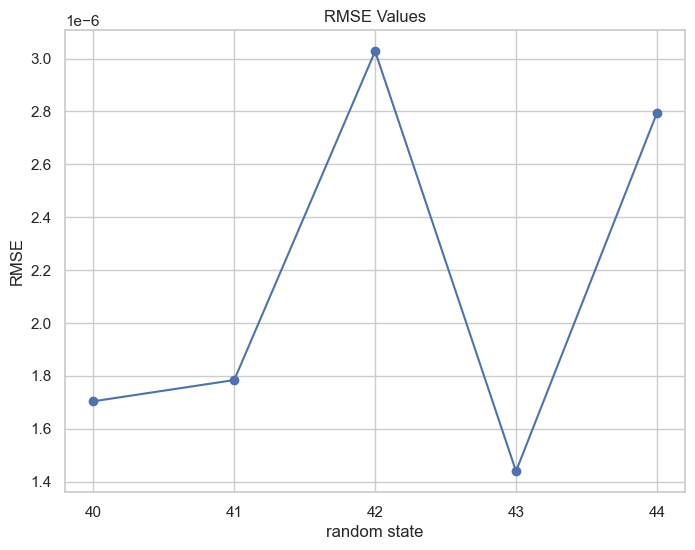

In [336]:
import matplotlib.pyplot as plt
import seaborn as sns

rmses = []

for i in range(40, 45):
    X_train, X_test, y_train, y_test = train_test_split(features, df["Price in Thousands"], test_size=0.1, random_state=i)
    chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train)
    predictions=predict_output(X_test ,train_weights,bias)
    RMSE=get_root_mean_square_error(predictions,y_test)
    rmses.append(RMSE)
    
plt.figure(figsize=(8, 6))
plt.plot(range(40, 45), rmses, marker='o')
plt.xlabel('random state')
plt.ylabel('RMSE')
plt.title('RMSE Values')
plt.xticks(range(40, 45))
plt.grid(True)
plt.show()

We also plot the learning curve:

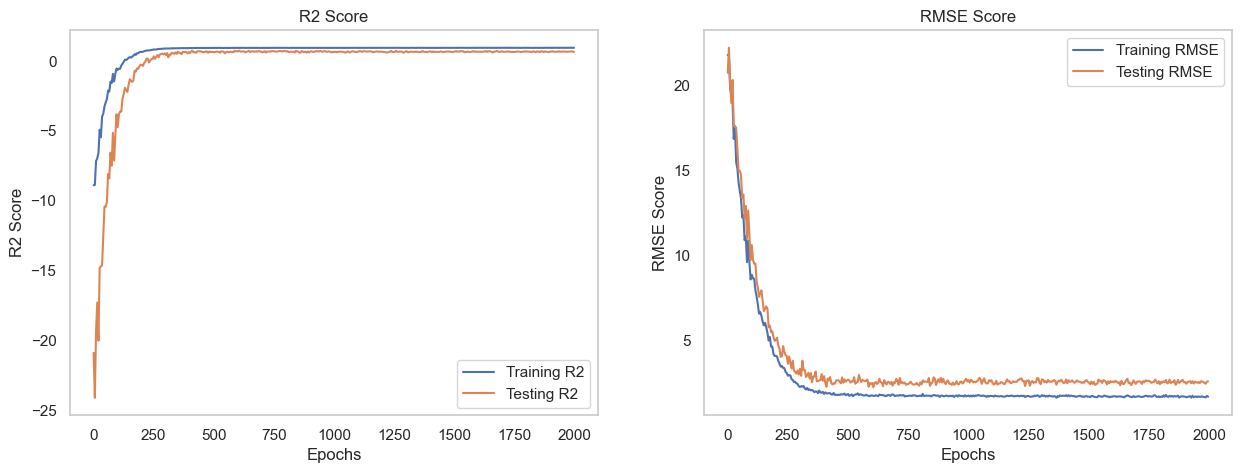

In [337]:
plot_learning_curve(X_train, y_train, X_test, y_test)

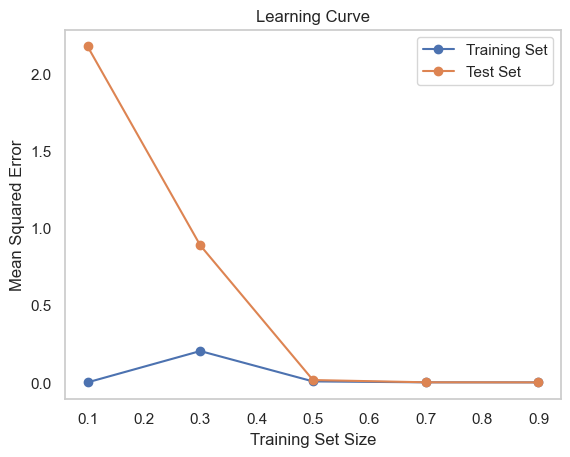

In [338]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
plot_real_learning_curve(X_train, y_train, X_test, y_test, train_sizes)

Then we use ```LinearRegression``` from ```sklearn``` to predict the target variable.

In [339]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Root Mean Squared Error: 1.1168622979385008e-08
R^2 Score: 1.0


#### Target Variable: Horsepower
We do all the steps above for ```Horsepower``` again.

In [340]:
from sklearn.model_selection import train_test_split

features = df.drop("Horsepower", axis = "columns")

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, df["Horsepower"], test_size=0.1, random_state=42)

In [341]:
chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train)
predictions=predict_output(X_test ,train_weights,bias)
R2_score=get_r2_score(predictions,y_test)
RMSE=get_root_mean_square_error(predictions,y_test)
print("Root Mean Squared Error:",RMSE)
print("R^2 Score:",R2_score)

Root Mean Squared Error: 5.483896624050955e-07
R^2 Score: 0.9999999999999999


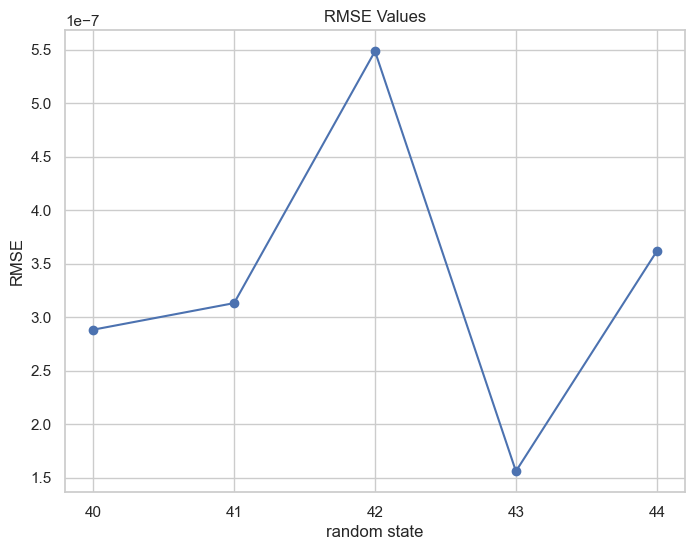

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

rmses = []

for i in range(40, 45):
    X_train, X_test, y_train, y_test = train_test_split(features, df["Horsepower"], test_size=0.1, random_state=i)
    chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train)
    predictions=predict_output(X_test ,train_weights,bias)
    RMSE=get_root_mean_square_error(predictions,y_test)
    rmses.append(RMSE)
    
plt.figure(figsize=(8, 6))
plt.plot(range(40, 45), rmses, marker='o')
plt.xlabel('random state')
plt.ylabel('RMSE')
plt.title('RMSE Values')
plt.xticks(range(40, 45))
plt.grid(True)
plt.show()

In [343]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Root Mean Squared Error: 1.2180937906473216e-08
R^2 Score: 1.0


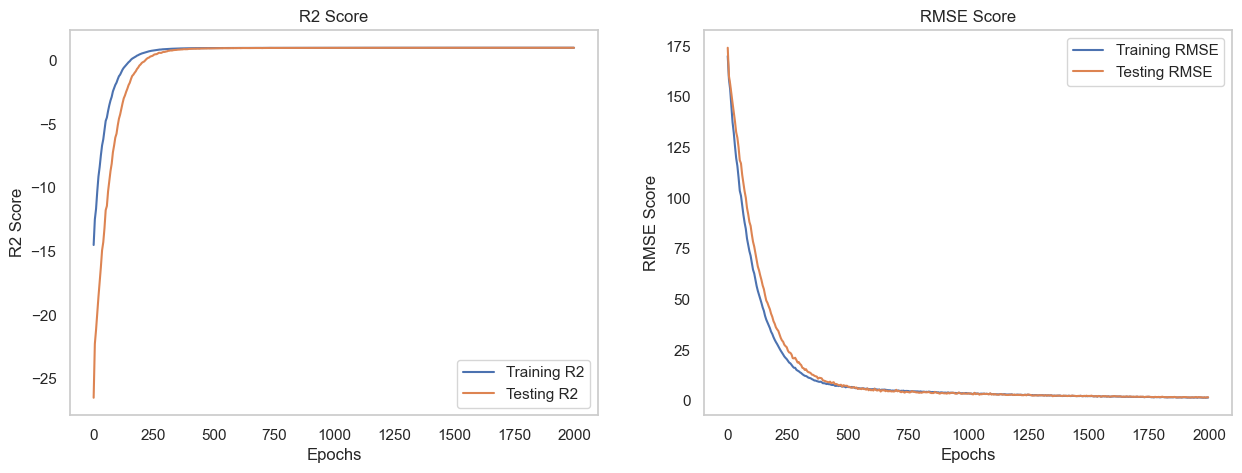

In [344]:
plot_learning_curve(X_train, y_train, X_test, y_test)

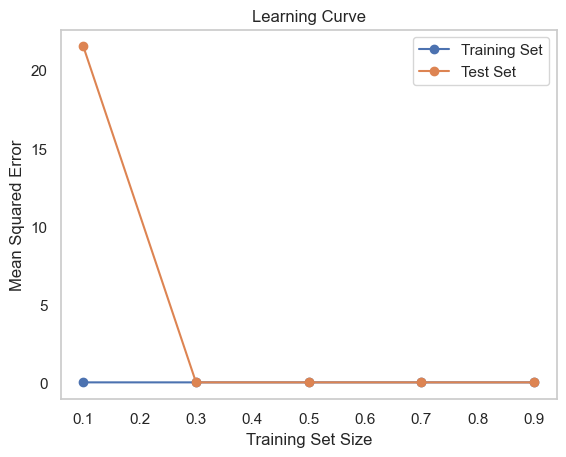

In [345]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
plot_real_learning_curve(X_train, y_train, X_test, y_test, train_sizes)

Both the implemented model and the scikit-learn model perform well in terms of the evaluated metrics. The scikit-learn model shows a slightly better performance with a slightly lower RMSE and a perfect R^2 score, indicating a better fit to the data and more accurate predictions. However, the difference in metrics between the two models is small, and it may not have a significant practical impact. 

The scikit-learn model benefits from being a widely-used and well-tested library that incorporates various optimizations and best practices for regression tasks. It has a large user community and ongoing development, ensuring its reliability and continuous improvement. 

Overall, while the scikit-learn model shows slightly better performance, the implemented model still performs well, and the choice between the two models should consider specific requirements and constraints.

## Part 3: Manual K-Fold Cross Validation Implementation

In this part, we should implement K-Fold cross-validation from scratch and compare it's result with results of using libraries. 

First, we implement k_fold_cross_validation from scratch. This function allows us to obtain the R^2 scores and RMSE scores for each fold, which can be used to evaluate the regression model's performance and assess its generalization capability.

In [358]:
def k_fold_cross_validation_scratch(X, y, k, max_epochs=MAX_EPOCHS):
    n = len(X)
    fold_size = n // k
    r2_scores = []
    rmse_scores = []
    train_rmse_scores = []
    train_r2_scores = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)
        X_val = X[start:end]
        y_val = y[start:end]
        
        chosen_feature_matrix, train_weights, bias = get_weights_and_bias(X_train, y_train, max_epochs=max_epochs)
        predictions=predict_output(X_val ,train_weights,bias)
        y_train_pred = predict_output(X_train, train_weights, bias)
        R2_score=get_r2_score(predictions,y_val)
        RMSE=get_root_mean_square_error(predictions,y_val)
        rmse_train = get_root_mean_square_error(y_train, y_train_pred)
        r2_train = get_r2_score(y_train_pred, y_train)

        r2_scores.append(R2_score)
        rmse_scores.append(RMSE)
        train_rmse_scores.append(rmse_train)
        train_r2_scores.append(r2_train)


    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    train_avg_rmse = np.mean(train_rmse_scores)
    train_avg_r2 = np.mean(train_r2_scores)
    
    return avg_r2, avg_rmse, train_avg_rmse, train_avg_r2

Then we use ```sklearn``` for k_fold_cross_validation.

In [347]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def k_fold_cross_validation_library(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    r2_scores = []
    rmse_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)

    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)

    return avg_r2, avg_rmse

Then, we use ```StandardScaler``` to prepare data to call ```k_fold_cross_validation``` function. We do this for the both target values. 

In [348]:
from sklearn.preprocessing import StandardScaler
from statistics import mean

X = df.drop("Horsepower", axis = "columns").to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = df["Horsepower"].to_numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(y)
y = scaler.transform(y).flatten()

In [349]:
avg_r2, avg_rmse, _, __ = k_fold_cross_validation_scratch(X, y, 5)
print("Average R2 Score:", avg_r2)
print("Average RMSE:", avg_rmse)

Average R2 Score: 0.9999999999995943
Average RMSE: 5.824934771947503e-07


In [350]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(X_train, y_train, X_test, y_test):
    train_scores_r2 = []
    test_scores_r2 = []
    train_scores_rmse = []
    test_scores_rmse = []
    epochs = range(1, 2000, 5)
    for i in epochs:
        #print(i)
        avg_r2, avg_rmse, train_avg_rmse, train_avg_r2 = k_fold_cross_validation_scratch(X, y, 5, max_epochs=i)
        train_scores_r2.append(train_avg_r2)
        test_scores_r2.append(avg_r2)
        train_scores_rmse.append(train_avg_rmse)
        test_scores_rmse.append(avg_rmse)
        
    
    ax, fig = plt.subplots(1, 2, figsize=(15, 5))
    fig[0].plot(epochs, train_scores_r2, label='Training R2')
    fig[0].plot(epochs, test_scores_r2, label='Testing R2')
    fig[0].set_title('R2 Score')
    fig[0].set_xlabel('Epochs')
    fig[0].set_ylabel('R2 Score')
    fig[0].legend()
    fig[1].plot(epochs, train_scores_rmse, label='Training RMSE')
    fig[1].plot(epochs, test_scores_rmse, label='Testing RMSE')
    fig[1].set_title('RMSE Score')
    fig[1].set_xlabel('Epochs')
    fig[1].set_ylabel('RMSE Score')
    fig[1].legend()

In [351]:
def plot_real_learning_curve_kfold(X_train, y_train, X_test, y_test, train_sizes):
    train_scores = []
    test_scores = []

    for size in train_sizes:
        train_subset_size = int(size * len(X_train))
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]

        _, avg_rmse, train_avg_rmse, __ = k_fold_cross_validation_scratch(X_train_subset, y_train_subset, 5)
        train_scores.append(train_scores)
        test_scores.append(test_scores)
    
    plt.plot(train_sizes, train_scores, marker='o', label='Training Set')
    plt.plot(train_sizes, test_scores, marker='o', label='Test Set')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

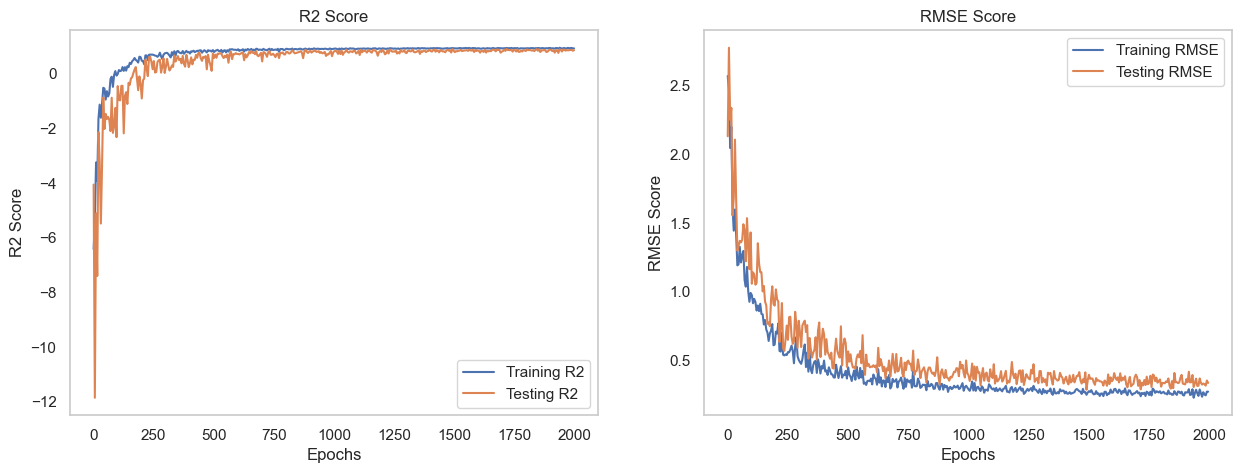

In [359]:
plot_learning_curve(X_train, y_train, X_test, y_test)

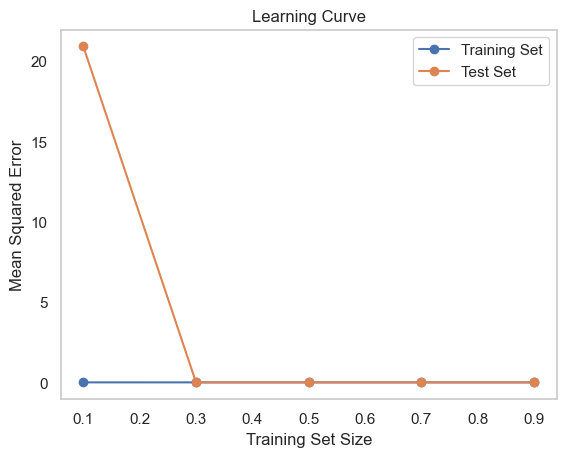

In [353]:
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
plot_real_learning_curve(X_train, y_train, X_test, y_test, train_sizes)

## Part 4: Comparison with Built-in Python Libraries

In [354]:
avg_r2, avg_rmse = k_fold_cross_validation_library(X, y, 5)
print("Average R2 Score:", avg_r2)
print("Average RMSE:", avg_rmse)

Average R2 Score: 1.0
Average RMSE: 3.841163009651555e-10


In [355]:
from sklearn.preprocessing import StandardScaler

X = df.drop("Price in Thousands", axis = "columns").to_numpy()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = df["Price in Thousands"].to_numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(y)
y = scaler.transform(y).flatten()

In [356]:
avg_r2, avg_rmse, _, __ = k_fold_cross_validation_scratch(X, y, 5)
print("Average R2 Score:", avg_r2)
print("Average RMSE:", avg_rmse)

Average R2 Score: 0.9999999999895456
Average RMSE: 2.921934656954441e-06


In [357]:
avg_r2, avg_rmse = k_fold_cross_validation_library(X, y, 5)
print("Average R2 Score:", avg_r2)
print("Average RMSE:", avg_rmse)

Average R2 Score: 1.0
Average RMSE: 2.219883626695605e-09


Both the custom implemented model and the scikit-learn model demonstrate strong performance when evaluated using the R2-Score. However, the scikit-learn model outperforms the custom implementation with a lower Root Mean Squared Error (RMSE), suggesting a closer fit to the data and more precise predictions. This distinction between the two approaches becomes more pronounced in this scenario, as we utilize k-fold cross-validation to evaluate the model's performance over multiple iterations and obtain an average case assessment.

Overall, the scikit-learn implementation provides a more concise and efficient solution, enabling a comprehensive evaluation of the model's performance. The utilization of k-fold cross-validation yields a more reliable estimate by considering multiple diverse subsets of the data.

## Questions

#### **1. Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?.**

We explained this in the report, Again we briefly mention our solutions:

* missing values: We dropped them because they were only few.
* categorical features: We used label encoding for all of them and we also merged some of the values of some columns because we only had few of them. The reason we only used label encoding and not other methods like one-hot encoding is because we wanted to keep our data simple so the model didn't need to be that complex.

We used `Mutual Information` to check which features are more informative about the target and we also used visualizations to check the relationship between features and target.

#### **2. Why didn’t we use regression to predict whether a shot would result in a goal?**

Because it's a classification problem and the target is not a continuous number so we can't use regression to predict whether a shot would result in goal.

#### **3. How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?**

As we mentioned in the report, using only accuracy is not a good metric because the target value is highly imbalance(inly 10% of the data is goal). So we can use other metrics that doesn't have this problem like `ROC AUC` or `F1 score`.
 
#### **4. Discuss the advantages and disadvantages of k-fold cross-validation. Can you also explain other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation?**

**Advantages of k-fold cross-validation:**
- Better utilization of data: k-fold cross-validation allows for the entire dataset to be used for both training and testing. Each data point is used in the testing set exactly once and in the training set k-1 times, leading to better utilization of available data.
- Robustness: k-fold cross-validation reduces the impact of data partitioning on model performance evaluation compared to a single train-test split. It provides a more reliable estimate of the model's performance by averaging the results over multiple iterations.
- Model assessment: k-fold cross-validation provides a more comprehensive assessment of the model's performance by evaluating it on multiple diverse subsets of the data. It helps to identify any variability or inconsistency in the model's performance across different subsets.

**Disadvantages of k-fold cross-validation:**
- Computational complexity: k-fold cross-validation requires training and evaluating the model k times, which can be computationally expensive, especially for large datasets or complex models.
- Variability: The performance of the model may vary across different folds due to the randomness in the partitioning of the data. This variability can sometimes make it challenging to interpret and compare the results across different folds.
- Bias-variance trade-off: The choice of k can affect the bias-variance trade-off. A smaller value of k (e.g., 5) tends to have lower bias but higher variance, while a larger value of k (e.g., 10) has lower variance but higher bias.

**Other types of cross-validation methods that address the limitations and issues associated with k-fold cross-validation include:**

- Stratified k-fold cross-validation: This method ensures that each fold contains approximately the same proportion of samples from each class. It is useful when dealing with imbalanced datasets where the distribution of classes is uneven.

- Leave-One-Out Cross-Validation (LOOCV): In LOOCV, each data point is used as a separate test set, and the remaining data is used for training. It is computationally expensive but provides the least biased estimate of the model's performance since it uses almost all the available data for training.

- Shuffle-Split Cross-Validation: This method randomly shuffles the data and splits it into train and test sets multiple times. It allows for more flexibility in specifying the size of the train and test sets and the number of iterations.

- Time Series Cross-Validation: Specifically designed for time series data, this method preserves the temporal order of the data during cross-validation. It ensures that the model is evaluated on past data and trained on future data, mimicking the real-world scenario.

- Repeated Cross-Validation: Repeated cross-validation performs k-fold cross-validation multiple times with different random partitions of the data. It helps to obtain a more reliable estimate of the model's performance by averaging the results over multiple random splits.

#### **5. What metrics did you use to evaluate your manual implementations of multivariate regression and k-fold cross-validation, and why did you choose them?**
- Root Mean Square Error (RMSE):

    - RMSE is a widely used metric for evaluating the accuracy of regression models. It measures the average magnitude of the residuals (the differences between predicted and actual values) by taking the square root of the mean of squared residuals.
    - The RMSE provides a single value that represents the average prediction error. A lower RMSE indicates better model performance, as it signifies smaller differences between predicted and actual values.
    - RMSE is particularly useful as it considers the magnitude of errors and is in the same unit as the target variable, making it easily interpretable and relatable to the problem domain.

- R-squared (R2) Score:
    - R2 score is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variables. It indicates how well the regression model fits the observed data.
    - R2 score ranges from 0 to 1, where 0 indicates that the model does not explain any variability in the data, and 1 signifies that the model perfectly predicts the target variable.
    - The R2 score is valuable in assessing the goodness of fit of a regression model. A higher R2 score suggests that the model captures a larger proportion of the variability in the data, indicating better performance.
    - R2 score is widely used due to its simplicity, interpretability, and ability to compare different models based on their predictive power.